# Part 1
This notebook processes the data

In [1]:
#load packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from causal_curve import GPS_Regressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load in the data
data = pd.read_csv("data/Algebra_Nation.csv")

# Data Processing

In [3]:
# process the data a bit
## separate Locale. to location rural and location size
data[['locationRural', 'locationSize']] = data["Locale."].apply(lambda x: pd.Series(str(x).split(": ")))

#convert to Small, Midsize, Large
data['locationSize'] = data['locationSize'].replace(['Fringe', 'Distant', 'Remote'], 'Small')

#conver to Urban, Rural
data['locationRural']= data['locationRural'].replace(['City', 'Suburb', 'Town'], 'Urban')

In [4]:
# test the possible values
data['locationRural'].unique()

array(['Urban', 'Rural'], dtype=object)

In [5]:
# scale the data appropriately
scaled_features = data.copy()

col_names = ['numOfStud2014', 'meanScale2012', 'lev1Perc2012', 'lev5Perc2012','perc.free.lunch','perc.reduced.lunch']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_features[col_names] = features
scaled_features

,Locale.,Charter,Magnet.,Title.I.School.,Students.,Teachers.,Free.Lunch.,Reduced.Lunch.,grade,numOfStud2012,...,users.with.test.yourself.during.challenge,is.AN,loginsPerExaminee,perc.free.lunch,perc.reduced.lunch,SeniorHigh,middleHigh,logLoginsPerExaminee,locationRural,locationSize
0,Suburb: Midsize,No,No,No,1650,80.0,403,106,9,281,...,5,1,1.689759,-1.100755,-0.354221,0,0,0.524586,Urban,Midsize
1,City: Large,No,Yes,Yes,638,53.0,426,28,9,84,...,2,0,2.960000,1.161868,-1.020642,0,0,1.085189,Urban,Large
2,City: Large,Yes,No,Yes,401,NaN,114,3,9,58,...,4,0,2.250000,-0.886782,-2.212551,0,0,0.810930,Urban,Large
3,City: Midsize,No,No,Yes,293,17.0,236,26,9,40,...,20,1,5.421053,1.897870,0.447725,0,0,1.690290,Urban,Midsize
4,Rural: Fringe,No,No,No,1684,78.0,135,51,9,232,...,1,0,0.042705,-1.977425,-1.465968,1,0,-3.153448,Rural,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,Suburb: Large,No,No,No,2139,118.0,711,210,9,357,...,2,1,2.677143,-0.629733,0.756770,0,0,0.984750,Urban,Large
444,Suburb: Large,No,No,No,2002,104.0,510,129,9,285,...,0,0,0.316151,-1.044638,-0.347898,0,0,-1.151535,Urban,Large
445,City: Large,No,Yes,Yes,146,14.0,107,10,9,24,...,0,0,0.500000,1.510049,-0.215055,0,0,-0.693147,Urban,Large
446,Town: Fringe,No,No,No,1094,57.0,358,64,9,215,...,0,0,0.004348,-0.657297,-0.542195,0,0,-5.438079,Urban,Small


***

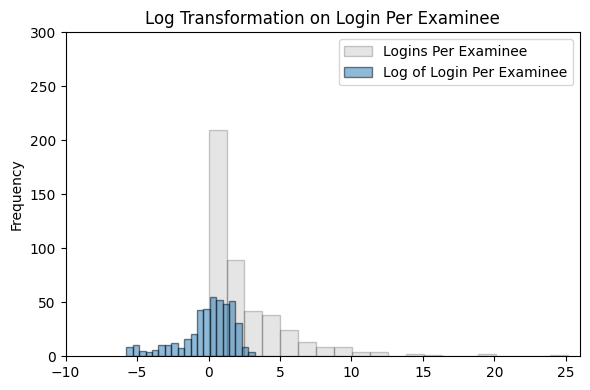

In [6]:
# plot the density of loginperexaminee and logLoginsPerExaminee
plt.figure(figsize=(6,4))

plt.hist(data['loginsPerExaminee'], 
         alpha=0.2, color = 'grey', # the transaparency parameter
         label='Logins Per Examinee',  bins=20,  histtype='bar', ec='black')
  
plt.hist(data['logLoginsPerExaminee'],
         alpha=0.5,
         label='Log of Login Per Examinee', bins=20,  histtype='bar', ec='black')

plt.legend(loc='upper right')
plt.title('Log Transformation on Login Per Examinee')
plt.xlim((-10,26))
plt.ylim((0,300))
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("images/logtrans.png", format="png", dpi=300)
plt.show()

***

In [7]:
# subset the data to keep the covariates we are interested
df = scaled_features[["Charter", #dummy indicator of charter school
                   "Magnet.", #dummy indicator of magnet school
                   "Title.I.School.", #dummy indicator of title 1 school
                   "locationRural",  #rural location
                   "locationSize", #size of location (large, midsize, small)
                   "Students.", #total number of students in 2012
                   "SeniorHigh" ,    #dummy indicator of whether it is a senior high school (the reference group is high school                          
                   "numOfStud2014", #number of test takers in 2014 
                   "meanScale2012", #mean scaled scores in 2012
                   "lev1Perc2012",#percent achieving level 1 in 2012
                   "lev5Perc2012", #percent achieving level 5 in 2012
                   "perc.free.lunch", #percent free lunch in 2012
                   "perc.reduced.lunch", #percent reduced lunch in 2012
                   "logLoginsPerExaminee", #treatment unit log (# of logins/ # of students in school who took algebra in Spring 2014)
                   "meanScale2014" #measured outcome
                   ]].copy()

In [8]:
df

,Charter,Magnet.,Title.I.School.,locationRural,locationSize,Students.,SeniorHigh,numOfStud2014,meanScale2012,lev1Perc2012,lev5Perc2012,perc.free.lunch,perc.reduced.lunch,logLoginsPerExaminee,meanScale2014
0,No,No,No,Urban,Midsize,1650,0,0.710319,1.321204,-1.189803,0.907034,-1.100755,-0.354221,0.524586,407
1,No,Yes,Yes,Urban,Large,638,0,-1.214175,0.339021,-0.853506,-0.424392,1.161868,-1.020642,1.085189,392
2,Yes,No,Yes,Urban,Large,401,0,-1.416359,-0.553873,0.491685,-0.690677,-0.886782,-2.212551,0.810930,386
3,No,No,Yes,Urban,Midsize,293,0,-1.633520,-1.536056,1.668728,0.108178,1.897870,0.447725,1.690290,383
4,No,No,No,Rural,Small,1684,1,0.328416,1.231914,-0.853506,1.439604,-1.977425,-1.465968,-3.153448,405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,No,No,No,Urban,Large,2139,0,0.845109,-0.018137,0.155388,0.108178,-0.629733,0.756770,0.984750,398
444,No,No,No,Urban,Large,2002,0,0.403299,0.339021,-0.433134,-0.424392,-1.044638,-0.347898,-1.151535,403
445,No,Yes,Yes,Urban,Large,146,0,-1.626032,0.428310,-1.189803,-0.690677,1.510049,-0.215055,-0.693147,405
446,No,No,No,Urban,Small,1094,0,-0.053488,0.874757,-0.853506,1.173319,-0.657297,-0.542195,-5.438079,408


In [9]:
# Process the data to allow direct plugin to package: Yes 1, No 0
df[['Charter','Magnet.','Title.I.School.']] = (df[['Charter','Magnet.','Title.I.School.']] == 'Yes').astype('int')
df[['locationRural']] = (df[['locationRural']] == 'Rural').astype('int')
df['locationSize']= df['locationSize'].astype('category').cat.codes
df['locationSize']= df['locationSize'].astype('int')
df['meanScale2014'] = df['meanScale2014'].astype('float')

In [10]:
#Save data for later use
df.to_csv('data/cleaned_data.csv',index=False)

***